<a href="https://colab.research.google.com/github/toruuno/DNN_d3d4/blob/master/3_3_predict_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4')
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4/lesson_3')
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4/common')
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4/data')

# predict sin

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### [try]
-  iters_numを100にしよう
-  maxlenを5, iters_numを500, 3000(※時間がかかる)にしよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def try_func(iters_num = 500,maxlen = 2):

    np.random.seed(0)

    # sin曲線
    round_num = 10
    div_num = 500
    ts = np.linspace(0, round_num * np.pi, div_num)
    f = np.sin(ts)

    def d_tanh(x):
        return 1/(np.cosh(x)**2 + 1e-4)

    # ひとつの時系列データの長さ
    #maxlen = 2

    # sin波予測の入力データ
    test_head = [[f[k]] for k in range(0, maxlen)]

    data = []
    target = []

    for i in range(div_num - maxlen):
        data.append(f[i: i + maxlen])
        target.append(f[i + maxlen])
        
    X = np.array(data).reshape(len(data), maxlen, 1)
    D = np.array(target).reshape(len(data), 1)

    # データ設定
    N_train = int(len(data) * 0.8)
    N_validation = len(data) - N_train

    x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

    input_layer_size = 1
    hidden_layer_size = 5
    output_layer_size = 1

    weight_init_std = 0.01
    learning_rate = 0.1

    #iters_num = 500

    # ウェイト初期化 (バイアスは簡単のため省略)
    W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
    W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
    W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

    # 勾配
    W_in_grad = np.zeros_like(W_in)
    W_out_grad = np.zeros_like(W_out)
    W_grad = np.zeros_like(W)

    us = []
    zs = []

    u = np.zeros(hidden_layer_size)
    z = np.zeros(hidden_layer_size)
    y = np.zeros(output_layer_size)

    delta_out = np.zeros(output_layer_size)
    delta = np.zeros(hidden_layer_size)

    losses = []

    # トレーニング
    for i in range(iters_num):
        for s in range(x_train.shape[0]):
            us.clear()
            zs.clear()
            z *= 0
            
            # sにおける正解データ
            d = d_train[s]

            xs = x_train[s]        
            
            # 時系列ループ
            for t in range(maxlen):
                
                # 入力値
                x = xs[t]
                u = np.dot(x, W_in) + np.dot(z, W)
                us.append(u)
                z = np.tanh(u)
                zs.append(z)

            y = np.dot(z, W_out)
            
            #誤差
            loss = functions.mean_squared_error(d, y)
            
            delta_out = functions.d_mean_squared_error(d, y)
            
            delta *= 0
            for t in range(maxlen)[::-1]:
                
                delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
                
                # 勾配更新
                W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
                W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
            W_out_grad = np.dot(z.reshape(-1,1), delta_out)
            
            # 勾配適用
            W -= learning_rate * W_grad
            W_in -= learning_rate * W_in_grad
            W_out -= learning_rate * W_out_grad.reshape(-1,1)
                
            W_in_grad *= 0
            W_out_grad *= 0
            W_grad *= 0

    # テスト        
    for s in range(x_test.shape[0]):
        z *= 0

        # sにおける正解データ
        d = d_test[s]

        xs = x_test[s]

        # 時系列ループ
        for t in range(maxlen):

            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            z = np.tanh(u)

        y = np.dot(z, W_out)

        #誤差
        loss = functions.mean_squared_error(d, y)
        print('loss:', loss, '   d:', d, '   y:', y)
            
            
            
    original = np.full(maxlen, None)
    pred_num = 200

    xs = test_head

    # sin波予測
    for s in range(0, pred_num):
        z *= 0
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            z = np.tanh(u)

        y = np.dot(z, W_out)
        original = np.append(original, y)
        xs = np.delete(xs, 0)
        xs = np.append(xs, y)

    plt.figure()
    plt.ylim([-1.5, 1.5])
    plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.show()

loss: 5.111112056304202e-07    d: [-0.47157024]    y: [-0.47258129]
loss: 1.4153640452727858e-06    d: [-0.39789889]    y: [-0.39958137]
loss: 2.5599029914894717e-06    d: [-0.78740743]    y: [-0.78967013]
loss: 7.2162632907901755e-09    d: [0.25526991]    y: [0.25514977]
loss: 1.692063852303836e-06    d: [0.6529121]    y: [0.6547517]
loss: 7.238070929585727e-07    d: [0.8773359]    y: [0.87613273]
loss: 6.946236726395298e-07    d: [0.92114593]    y: [0.91996727]
loss: 1.2284734878715097e-06    d: [-0.58880346]    y: [-0.59037093]
loss: 1.2497465540405892e-08    d: [-0.6529121]    y: [-0.65307019]
loss: 1.7470122273519936e-06    d: [-0.32751865]    y: [-0.32938788]
loss: 2.0214401036935557e-07    d: [0.39789889]    y: [0.39853473]
loss: 1.7248378220184066e-06    d: [-0.15674537]    y: [-0.1586027]
loss: 1.3462666565767213e-06    d: [0.97076771]    y: [0.97240861]
loss: 6.884294927340995e-07    d: [-0.50453668]    y: [-0.50571008]
loss: 8.96448514571133e-09    d: [-0.99460929]    y: [-0

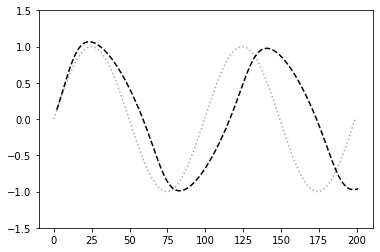

In [4]:
#default状態での実行
try_func(iters_num = 500,maxlen = 2)

#元々位相遅れが顕著な波形ではある

loss: 1.001821168835294e-06    d: [-0.47157024]    y: [-0.47298574]
loss: 3.8316285817396264e-05    d: [-0.39789889]    y: [-0.38914489]
loss: 1.195550219244669e-05    d: [-0.78740743]    y: [-0.79229732]
loss: 5.688169957024536e-07    d: [0.25526991]    y: [0.25633651]
loss: 5.042766131764598e-06    d: [0.6529121]    y: [0.65608787]
loss: 2.323535484703819e-05    d: [0.8773359]    y: [0.87051895]
loss: 1.2851597420608287e-05    d: [0.92114593]    y: [0.9160761]
loss: 2.9577805540610366e-06    d: [-0.58880346]    y: [-0.59123566]
loss: 5.3033087017894245e-05    d: [-0.6529121]    y: [-0.64261325]
loss: 3.068291439526518e-05    d: [-0.32751865]    y: [-0.31968501]
loss: 5.63868323222965e-07    d: [0.39789889]    y: [0.39896084]
loss: 1.413552384893668e-05    d: [-0.15674537]    y: [-0.15142832]
loss: 1.3233060812017836e-05    d: [0.97076771]    y: [0.97591224]
loss: 1.3588146407511827e-06    d: [-0.50453668]    y: [-0.50618521]
loss: 1.3524103237957192e-07    d: [-0.99460929]    y: [-0.

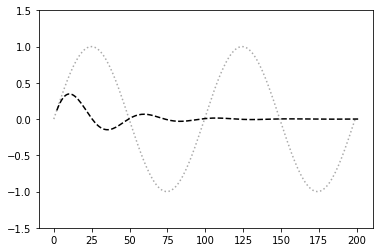

In [5]:
#iters_numを100にしてみよう
try_func(iters_num = 100,maxlen = 2)

#精度ガタ落ちする

loss: 1.910653011300673e-06    d: [-0.29761864]    y: [-0.29566383]
loss: 4.009145134729275e-06    d: [-0.56307233]    y: [-0.56024067]
loss: 4.117004181533802e-06    d: [-0.65766776]    y: [-0.65479826]
loss: 1.2186275784359606e-06    d: [0.13182648]    y: [0.13026531]
loss: 2.856909186221314e-06    d: [0.49909101]    y: [0.49670065]
loss: 2.9683545816401188e-05    d: [0.9518317]    y: [0.9441267]
loss: 3.027614372135897e-05    d: [0.97784112]    y: [0.97005959]
loss: 3.4625189230118902e-06    d: [-0.58880346]    y: [-0.58617192]
loss: 1.6259323267398064e-05    d: [-0.78351093]    y: [-0.77780842]
loss: 2.265698201958615e-06    d: [-0.49909101]    y: [-0.4969623]
loss: 1.582143105988781e-06    d: [0.21857331]    y: [0.21679447]
loss: 2.3430828768780229e-07    d: [-0.33938943]    y: [-0.33870488]
loss: 2.5337797976267956e-06    d: [-0.43793098]    y: [-0.43567986]
loss: 2.061751849314868e-06    d: [-0.33346065]    y: [-0.33143001]
loss: 2.3604686128432536e-05    d: [-0.99639027]    y: 

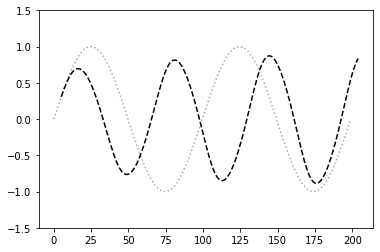

In [6]:
#iters_num = 500,maxlen = 5,に変更
try_func(iters_num = 500,maxlen = 5)

#逆に位相が進んで見えるけど
#maxlenの長さが長いとそのサンプルにおける波形の先読み要素が多くなるので
#学習が不十分だと位相進みが顕著になる傾向なのか?と素人推測してみる

loss: 1.0231756688222737e-07    d: [-0.29761864]    y: [-0.29716628]
loss: 1.2201090156041725e-08    d: [-0.56307233]    y: [-0.56322854]
loss: 4.038245320901024e-11    d: [-0.65766776]    y: [-0.65765877]
loss: 1.012613171470193e-08    d: [0.13182648]    y: [0.13168417]
loss: 6.953992391246068e-08    d: [0.49909101]    y: [0.49871807]
loss: 5.5838333193039375e-08    d: [0.9518317]    y: [0.95149752]
loss: 1.006541644062743e-07    d: [0.97784112]    y: [0.97739245]
loss: 1.7033534573325946e-08    d: [-0.58880346]    y: [-0.58861889]
loss: 5.2622812685924356e-08    d: [-0.78351093]    y: [-0.78383534]
loss: 2.60918282588755e-10    d: [-0.49909101]    y: [-0.49906816]
loss: 5.712849721315155e-08    d: [0.21857331]    y: [0.21823529]
loss: 9.126545094849141e-08    d: [-0.33938943]    y: [-0.3389622]
loss: 1.0304339135538811e-07    d: [-0.43793098]    y: [-0.43747701]
loss: 1.1445752972814562e-07    d: [-0.33346065]    y: [-0.3329822]
loss: 4.487028896407404e-08    d: [-0.99639027]    y: [

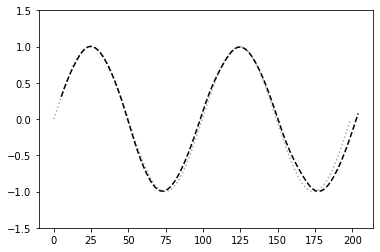

In [7]:
#iters_num = 3000,maxlen = 5,に変更
try_func(iters_num = 3000,maxlen = 5)

#まぁ精度が高く見える

loss: 3.912343122231309e-07    d: [-0.47157024]    y: [-0.47245481]
loss: 1.3052648322200394e-06    d: [-0.39789889]    y: [-0.39951461]
loss: 2.4568661324792026e-06    d: [-0.78740743]    y: [-0.78962413]
loss: 1.836933553803986e-08    d: [0.25526991]    y: [0.25507824]
loss: 1.5234519740797024e-06    d: [0.6529121]    y: [0.65465764]
loss: 5.187974276348698e-07    d: [0.8773359]    y: [0.87631727]
loss: 5.147787696348657e-07    d: [0.92114593]    y: [0.92013126]
loss: 1.0581260161824844e-06    d: [-0.58880346]    y: [-0.5902582]
loss: 3.273298436623086e-08    d: [-0.6529121]    y: [-0.65316796]
loss: 1.577987966024491e-06    d: [-0.32751865]    y: [-0.32929515]
loss: 1.336466170586074e-07    d: [0.39789889]    y: [0.3984159]
loss: 1.5368537747222136e-06    d: [-0.15674537]    y: [-0.15849857]
loss: 1.3150157772970742e-06    d: [0.97076771]    y: [0.97238945]
loss: 5.488011547345474e-07    d: [-0.50453668]    y: [-0.50558435]
loss: 3.4729876467868902e-09    d: [-0.99460929]    y: [-0.

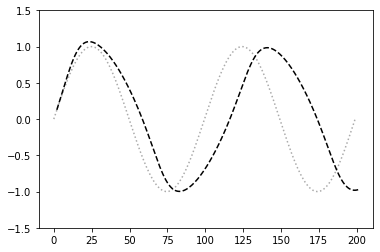

In [8]:
#iters_num = 3000,maxlen = 2,に変更
try_func(iters_num = 3000,maxlen = 2)


#これは単なる興味本位
#単に結果を見ておくだけの事
#結果、500回のイテレーションと大差なし